# De Rham Neural Networks

In this notebook, we develop a few examples of simple De Rham Neural Networks.

In [2]:
import numpy as np
from scipy import sparse
from scipy.sparse import coo_matrix,diags
from scipy.sparse.linalg import inv
import gudhi as gd
import copy
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import torch

import torch
import torch.nn as nn
 

## Vector Fields

We first design some plotting functions to visualize vector fields. This will help us understand the features that our algorithm is learning. 

In [3]:
## initialise a random function from R^n to R^2
def random_linear_function(input, output_dim = 2):

    # get the dimension of the input
    input_dim = np.shape(input)[0]

    # initialise a random matrix of dim input_dim x output_dim
    A = np.random.uniform(-1,1,(input_dim,output_dim))
    
    return input @ A


## plot a vector field given a function f: R^2 -> R^2
def plot_vector_field(f, x_range, y_range, ax):

    x = np.linspace(x_range[0],x_range[1],20)
    y = np.linspace(y_range[0],y_range[1],20)
    X,Y = np.meshgrid(x,y)


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            U[i,j] = f([X[i,j],Y[i,j]])[0]
            V[i,j] = f([X[i,j],Y[i,j]])[1]
    ax.quiver(X,Y,U,V)

    

## plot the vector field of a random function
def plot_random_vector_field():
    f = random_function()
    fig, ax = plt.subplots()
    plot_vector_field(f, [-1,1], [-1,1], ax)
    plt.show()

As a first example, we will consider vector fields over $\mathbb{R}^2$. $1$-forms, which are in bijection with and dual to vector fields, can be written in the form:
$\begin{equation} \omega = f_x(x,y) dx + f_y(x,y) dy \end{equation}$ where both $f_x$ and $f_y$ are functions from $\mathbb{R}^2$ to $\mathbb{R}$. By the identification
$ \begin{equation} \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \oplus  \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \cong \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}^2)  \end{equation}$ we can represent a $1$-form as a single function from $\mathbb{R}^2 \to \mathbb{R}^2$. To learn such a function, we define a simple MLP below which goes from $\mathbb{R}^2 \to \mathbb{R}^2$.

In [5]:
import torch
import torch.nn as nn
 
# initialise a vector field as a MLP
vf = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 500),
    nn.ReLU(),
    nn.Linear(500, 2)
)

To drive home the fact that the above MLP actually defines a vector field, we can plot it. The 'tangent vector' at each point $(x,y) \in \mathbb{R}^2$ is the vector given by
$\begin{equation}  (f_x(x,y),f_y(x,y)) \end{equation}$ which corresponds to the MLP above via
$\begin{equation} f_x(x,y) = \pi_x \circ \text{vf.forward}(x,y) \end{equation}$ and $\begin{equation} f_y(x,y) = \pi_y \circ \text{vf.forward}(x,y). \end{equation}$

IndexError: too many indices for tensor of dimension 1

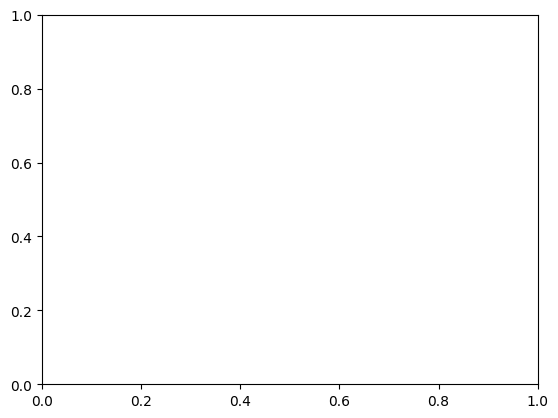

In [6]:
## plot a vector field given a function f: R^2 -> R^2
def plot_vector_field(f, ax, x_range=5, y_range=5):

    x = np.linspace(-x_range,x_range,20)
    y = np.linspace(-y_range,y_range,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()
            U[i,j] = f.forward(inp)[0,0]
            V[i,j] = f.forward(inp)[0,1]
    ax.quiver(X,Y,U,V)

fig, ax = plt.subplots()

plot_vector_field(vf, ax, x_range=100, y_range=100)

plt.show()


In [7]:
## plot a vector field given a function f: R^2 -> R^2
def plot_component_vf(f, ax, comp = 0, x_range=5, y_range=5):

    x = np.linspace(-x_range,x_range,20)
    y = np.linspace(-y_range,y_range,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()

            tv = f.forward(inp).reshape(2,c)

            U[i,j] = tv[:,comp][0]
            V[i,j] = tv[:,comp][1]
    ax.quiver(X,Y,U,V)


Now we make a neural network that learns multiple vector fields.

In [8]:
c = 6 # number of features/columns in cochain data matrix

vf = nn.Sequential(
    nn.Linear(2, 2*c)
)

#vf.forward(torch.tensor([1,2]).float()).reshape(2,c)

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_806/625976827.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, i+1)


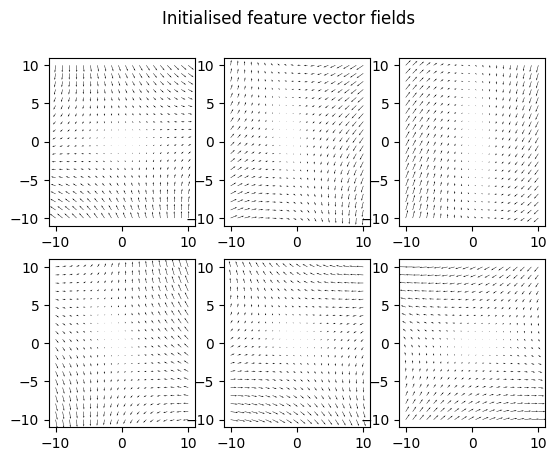

In [9]:
fig, ax = plt.subplots()

# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(c):
    ax = plt.subplot(2, 3, i+1)
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)


# add a title to the figure
fig.suptitle('Initialised feature vector fields')


plt.show()


#### Calculating line integrals of vector fields along linear paths

In [10]:
# parametrize a line between two points
def line(x,y,n = 50):
    
    t = np.linspace(0,1,n)

    # make t into a column vector
    t = np.reshape(t, (n,1))

    return torch.tensor((1-t) @ x + t @ y).float()

In [11]:
l = line(np.array([[0,1]]),np.array([[1,0]]))

In [12]:
def trapz(y, l):
    """Approximate the definite integral of y=f(x) using the trapezoidal rule.

    Parameters
    ----------
    y : array_like
        Array of y values of f(x).
    l : array_like
        Array of linear values along a line in R^n.
    
    Returns
    -------
    trapz : float
        Definite integral as approximated by trapezoidal rule.

    """

    # difference between each point on the line, should be 1x(n-1)
    d = torch.norm(torch.diff(l.T).T,dim=1)

    # pointwise multiplication of y[0:-1] + y[1:] and d
    return d @ (y[0:-1,:] + y[1:,:]) / 2

In [13]:
def vf_eval(vf,line):
    # evaluate the vector field vf along the line
    # vf is a torch.nn.Sequential object
    # line is a torch.tensor object
    # returns a torch.tensor object
    n = line.shape[0]
    

    # gradient of the line
    l_grad = (line[-1] - line[0])/np.linalg.norm(line[-1] - line[0])

    # turn l_grad into a column vector that automatically determines the number of rows
    l_grad = torch.reshape(l_grad, (l_grad.shape[0],1))

    # initialise empty torch tensor of size n x c
    # where c is the number of features in the cochain data matrix 
    # and n is the number of points in the line
    out = torch.zeros((n,c))

    # iterate over the columns of the cochain data matrix/number of feature 1-forms
    for j in range(c):

        # initialise empty torch tensor of size n x 2 to store innerproduct of
        # vf[j] and the gradient of the line
        local_out = torch.zeros((n,2))

        for i in range(n):
            local_out[i,:] = vf(line[i,:]).reshape((2,c))[:,j]
        
        out[:,j] = (local_out @ l_grad).T

    # return a torch tensor of size n x c
    # where n is the number of points in the line
    # and c is the number of features in the cochain data matrix
    # entries represent the inner product of the vector field 
    # and the gradient of the line at each point in the line
    return out

In [14]:
def integrate(vf,l):
    """ 
    Parameters
    ----------
    vf : torch.nn.Sequential object
        Vector field to be integrated
    l : torch.tensor object
        Line along which to integrate vf
    """
    eval = vf_eval(vf,l)
    return trapz(eval,l)

In [15]:
# integrate a vector field between two points with a given number of steps
def integrate_segment(vf, x, y, n = 5):
    """
    Parameters
    ----------
    vf : torch.nn.Sequential object
        Vector field to be integrated
    x : torch.tensor object
        Starting point of the line
    y : torch.tensor object
        End point of the line
    n : int
        Number of steps to take along the line
    """
    l = line(x,y,n)
    
    return integrate(vf,l)



In [16]:
def generate_cochain_dm(vf, points, n = 50):
    """
    A function to generate the cochain data matrix for a path of points in R^m
    against a vector field
    ----------

    Parameters
    ----------
    vf : torch.nn.Sequential object
        Vector field to be integrated
    points : torch.tensor object (m x r)
        Sequence of points in R^m representing a path
    n : int
        Number of steps to take along each line
    """

    r = points.shape[0]-1

    # initialise empty torch tensor of size r x c
    # where c is the number of features in the cochain data matrix
    # and r is the number of lines between points
    out = torch.zeros((r,c))

    for i in range(r):
        out[i,:] = integrate_segment(vf,np.array([points[i,:]]),np.array([points[i+1,:]]), n = n)

    return out

## Alternative Integration Methods


In [17]:
# a simple 1-chain is a represented by a list of 1-simplices in R^n
# we will store this as an array of shape (r, 2, n)
# the middle dimension represents the starting and ending vertices of the 1-simplex
p = paths[0]

r = len(p) - 1

n = p[0].shape[0]

d = 5

# initialise empty torch tensor of size r x d x n
# where r is the number of 1-simplices in the 1-chain, d is number of discrete steps, n is the dimension of the ambient space  

chain = torch.zeros((r,d,n))

end = p[1:,:]
start = p[0:-1,:]

t = np.linspace(0,1,d)

print("t = ", t)
for i in range(d):

    chain[:,i,:] = (1-t[i]) * torch.tensor(start) + t[i] * torch.tensor(end)

chain.shape

# chain is a torch tensor of shape (r, d, n), where (r,0,n) is the starting points

# for higher k-chains, we would have (r, k+1, n) where
#  -    k is the dimension of the simplex
#  -    r is the number of k-simplices in the k-chain
#  -    n is the dimension of the ambient space



NameError: name 'paths' is not defined

In [18]:
(chain[:,1,:] - chain[:,0,:]).shape

NameError: name 'chain' is not defined

In [103]:
# turning a chain into a cochain data matrix
# first we evaluate the vector field on a chain
# this gives us a tensor of shape (r, 2, n, c)

out = vf(chain).reshape((r,d,n,c))

out.shape


torch.Size([49, 5, 2, 3])

In [104]:
# calculate the simplex gradients
simplex_grad = torch.tensor(end - start).float()

print(simplex_grad.shape)

n = 2

# calculate the inner product of the vector field and the simplex gradients
# pointwise inner product of [i,j,:,k]  and [i,:] for all i,j,k

# initialise empty torch tensor of size r x d x c
# where r is the number of 1-simplices in the 1-chain, d is number of discrete steps, c is the number of features in the cochain data matrix

inner_prod = torch.zeros((r,d,c))

for i in range(r):
    for j in range(d):
        for k in range(c):
            inner_prod[i,j,k] = out[i,j,:,k].T @ simplex_grad[i,:]/(d-1)



print(inner_prod.shape)

torch.Size([49, 2])
torch.Size([49, 5, 3])


In [107]:
torch.matmul(out,simplex_grad)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (490x3 and 49x2)

In [128]:
# swap dimensions n and c in out
out2 = out.permute(0,1,3,2)

out3 = torch.matmul(out2,simplex_grad.T/(d-1))

print(out2.shape)
print(simplex_grad.T.shape)
print(out3.shape)

# take diagonal of out3 along axis 0 and 3
out4 = torch.diagonal(out3, dim1 = 0, dim2 = 3)

print(out4.shape)

# permute dimensions 0 and 2 of out4
out5 = out4.permute(2,0,1)

print(out5.shape)

print(out5 - inner_prod)



torch.Size([49, 5, 3, 2])
torch.Size([2, 49])
torch.Size([49, 5, 3, 49])
torch.Size([5, 3, 49])
torch.Size([49, 5, 3])
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.8626e-09,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -4.6566e-10,  0.0000e+00],
         [ 3.7253e-09, -4.6566e-10,  0.0000e+00],
         [ 0.0000e+00,  4.6566e-10,  0.0000e+00],
         [ 0.0000e+00, -4.6566e-10,  3.7253e-09],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.8626e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -9.3132e-10,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0

In [106]:
## make simplex_grad into an tensor of shape (r,d,n,c) by copying along c and d axis
b = simplex_grad.reshape((r,1,n,1)).repeat(1,d,1,c)

print(b.shape)

print(out.shape)
## 
sg = b.reshape(-1,n)
ot = out.reshape(-1,n)

print(sg.shape)
print(ot.shape)

out2 = torch.diag(ot @ sg.T)

print(out2.shape)

out2 = out2.reshape((r,d,c))

out2.shape

out2 == inner_prod




torch.Size([49, 5, 2, 3])
torch.Size([49, 5, 2, 3])
torch.Size([735, 2])
torch.Size([735, 2])
torch.Size([735])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (490x3 and 49x2)

In [77]:
a = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2

a.shape

a = a.sum(axis = 1)

a.shape

torch.Size([49, 6])

In [81]:
vf[-1].out_features / 2

6.0

In [19]:
# a function for turning a path into a chain
def path_to_chain(p):

    r = len(p) - 1

    n = p[0].shape[0]
    
    
    chain = torch.zeros((r,2,n))

    chain[:,1,:] = torch.tensor(p[1:,:])
    chain[:,0,:] = torch.tensor(p[0:-1,:])

    return chain

    
# a function for turning a chain into a discretized chain
def discretize_chain(chain,d):

    r = chain.shape[0]

    n = chain.shape[2]

    d_chain = torch.zeros((r,d,n))

    t = np.linspace(0,1,d)

    for i in range(d):

        d_chain[:,i,:] = (1-t[i]) * chain[:,0,:] + t[i] * chain[:,1,:] 

    return d_chain



In [20]:
#
def gen_CDM(vf,chain, d = 5):

    chain = discretize_chain(chain, d)

    # number of simplicies
    r = chain.shape[0]

    # number of discrete steps
    d = chain.shape[1]

    # dimension of ambient space
    n = chain.shape[2]

    # number of feature-cochains in the cochain data matrix
    c = int(vf[-1].out_features / n)



    out = vf(chain).reshape((r,d,n,c))

    # calculate the simplex gradients
    simplex_grad = chain[:,1,:] - chain[:,0,:]

    # initialise empty torch tensor of size r x d x c
    inner_prod = torch.zeros((r,d,c))

    # calculate the inner product of the vector field and the simplex gradients
    # Would be great to get rid of this for-loop somehow
    for i in range(r):
        for j in range(d):
            for k in range(c):
                inner_prod[i,j,k] = (out[i,j,:,k].T @ simplex_grad[i,:]) /(d-1)



    cdm = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2


    cdm = cdm.sum(axis = 1)

    return cdm

In [21]:
# swap dimensions n and c in out

def gen_CDM2(vf,chain, d = 5):

    chain = discretize_chain(chain, d)

    # number of simplicies
    r = chain.shape[0]

    # number of discrete steps
    d = chain.shape[1]

    # dimension of ambient space
    n = chain.shape[2]

    # number of feature-cochains in the cochain data matrix
    c = int(vf[-1].out_features / n)


    # apply the vector field to the discretized chain
    out = vf(chain).reshape((r,d,n,c))

    # calculate the simplex gradients
    simplex_grad = chain[:,1,:] - chain[:,0,:]

    out = out.permute(0,1,3,2)

    out = torch.matmul(out,simplex_grad.T/(d-1))


    # take diagonal of out3 along axis 0 and 3
    out = torch.diagonal(out, dim1 = 0, dim2 = 3)


    # permute dimensions 0 and 2 of out4
    inner_prod = out.permute(2,0,1)

    # apply the trapzoidal rule to the inner product
    cdm = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2
    cdm = cdm.sum(axis = 1)

    return cdm



In [22]:
chain = path_to_chain(paths[0])

NameError: name 'paths' is not defined

In [23]:
X = gen_CDM(vf,chain, d= 500)

NameError: name 'chain' is not defined

In [24]:
Y = gen_CDM2(vf,chain, d=500)

NameError: name 'chain' is not defined

In [25]:
# the input should be a set of vector field and a set of 1-simplices, where
# 1-simplices are represented as a set of points in R^n

vf(torch.tensor([[1,2],[0,2]]).float())

# idea is to send all points into vf at once to get all the tangent vector

vf(torch.tensor([[[1,2],[0,2]],[[1,2],[0,2]]]).float()).shape

torch.Size([2, 2, 12])

In [26]:
paths[0].shape



NameError: name 'paths' is not defined

### Synthetic Dataset of paths

In [27]:
## plot a set of points and connect consecutive points with lines
def plot_points(points, ax, color = 'black', alpha = 1, linewidth = 1):

    n = points.shape[0]

    for i in range(n-1):
        ax.plot(points[i:i+2,0],points[i:i+2,1], color = color, alpha = alpha, linewidth = linewidth)

    return ax


In [28]:
def generate_diagonal_paths(num_paths=100,eps = 0.02, num_pts = 50):
    
    Paths = []
    for i in range(num_paths): 
        x = np.sort(np.random.uniform(low=-1, high=1, size=num_pts))
        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-2,2)
        y_trans = np.random.randint(-2,2)

        r = np.random.uniform(0.2, 2.5)

        x_values = list(r*x+noise_x+x_trans)
        y_values = list(r*np.sin(x+noise_y)+ y_trans)

        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)
        
    return Paths


def generate_antidiagonal_paths(num_paths=100,eps = 0.01, num_pts = 50):
    
    Paths = []
    for i in range(num_paths): 
        x = np.sort(np.random.uniform(low=-1, high=1, size=num_pts))

        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-2,2)
        y_trans = np.random.randint(-2,2)

        r = np.random.uniform(0.2, 2.5)

        x_values = list(r*x+noise_x + x_trans)
        y_values = list(-r*np.sin(x+noise_y)+y_trans)
        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)
        
    return Paths
        



def generate_circular_paths(num_paths=100,eps = 0.02, num_pts = 50):
    
    Paths = []
    for i in range(num_paths): 
        endpoint = np.random.randint(0,num_pts)

        k = np.random.randint(1,4)
        phase = np.random.uniform(0,2*np.pi)
        
        sample_angles = list(np.sort(np.random.uniform(0,2*np.pi/k, num_pts)+phase))

        #angles= sample_angles[endpoint:]+ sample_angles[:endpoint]
        angles = np.array(sample_angles)
        
        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-5,5)
        y_trans = np.random.randint(-5,5)

        r = np.random.uniform(0.2, 2.5)

        x_values = r*np.cos(angles)+noise_x
        y_values = r*np.sin(angles)+noise_y

        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)

    return Paths

In [29]:
# generate data
noise = 0.05
pts = 30

p0 = generate_diagonal_paths(num_paths=100,eps = noise, num_pts = 50)
p1 = generate_antidiagonal_paths(num_paths=100,eps = noise, num_pts = 50)
p2 = generate_circular_paths(num_paths=100,eps = noise, num_pts = 50)

# join together p0, p1, p2
paths = p0+p1+p2

In [30]:
# generate labels
labels = np.concatenate((np.zeros(100),np.ones(100),2*np.ones(100)))

# perform a one hot encoding of the labels and transform to torch
labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

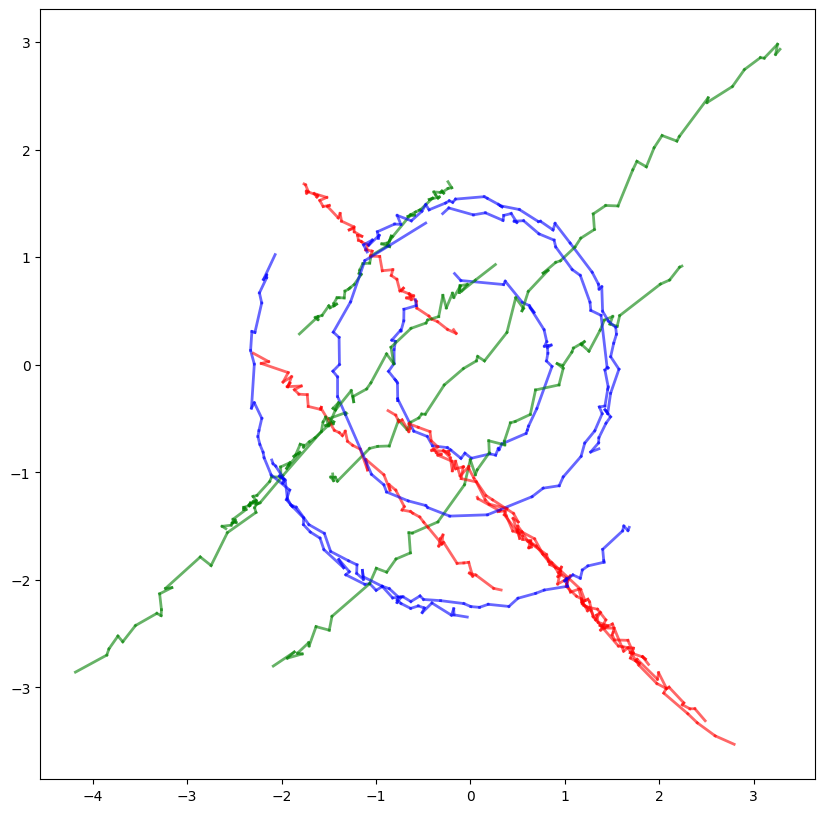

In [31]:
fig, ax = plt.subplots(1,1,figsize = (10,10))

for i in range(5):


    plot_points(paths[0+i], ax, color = 'green', alpha = 0.6, linewidth = 2)

    plot_points(paths[100+i], ax, color = 'red', alpha = 0.6, linewidth = 2)

    plot_points(paths[200+i], ax, color = 'blue', alpha = 0.6, linewidth = 2)

plt.show()

In [32]:
# a function for calculating the length of a path
def path_length(path):
    """
    Calculates the length of a path
    """
    length = 0
    for i in range(len(path)-1):
        length += np.linalg.norm(path[i+1]-path[i])
    return length

In [33]:
path_length(paths[0])

2.861017595818407

### Running the model

In [34]:
class LengthMax(nn.Module):
    """
    A custom layer that takes normalises the vectors in the vector field
    by the sigmoid of their norm
    """
    def __init__(self, m, length = 1):
        super().__init__()
        self.m = m # embedding dimension
        self.length = length # length of the vectors

    def forward(self, x):

        x = x.reshape(self.m,-1)


        lengths = torch.sqrt(torch.diag(x.T @ x))

        # replace lengths with max(length,1)
        lengths = torch.max(lengths,torch.ones_like(lengths))


        x = x * (1/lengths)


        x = x.reshape(1,-1)

        return x

In [64]:
c = 3 # number of features/columns in cochain data matrix

vf = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 30),
    nn.ReLU(),
    nn.Linear(30, 2*c)
)

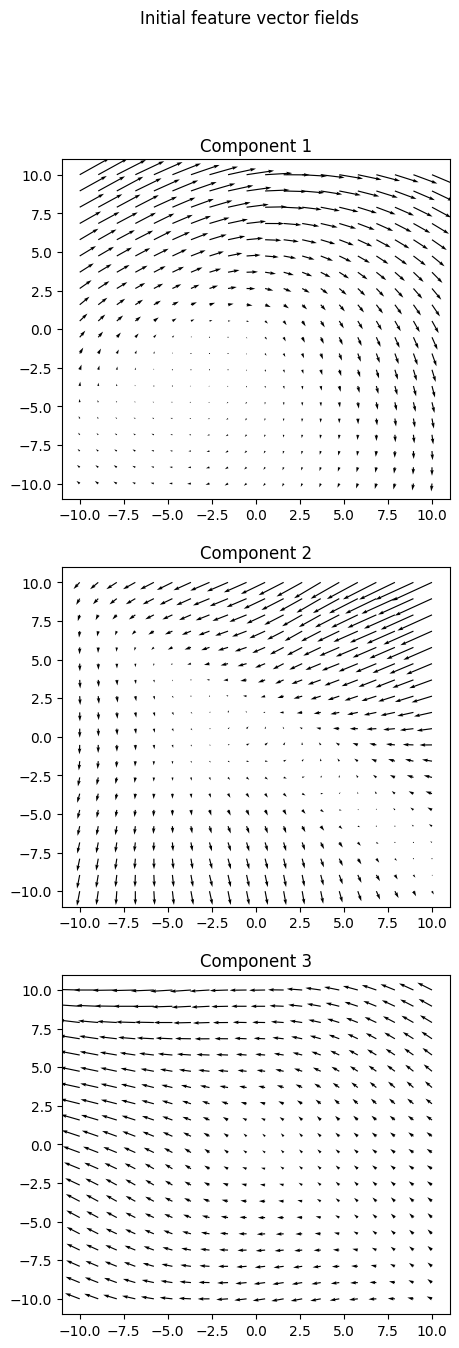

In [65]:
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i in range(3):
    ax = axs[i]
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)
    ax.set_title('Component {}'.format(i+1))

# add a title to the figure
fig.suptitle('Initial feature vector fields')

plt.show()

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_806/334403156.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy: 0.30333333333333334


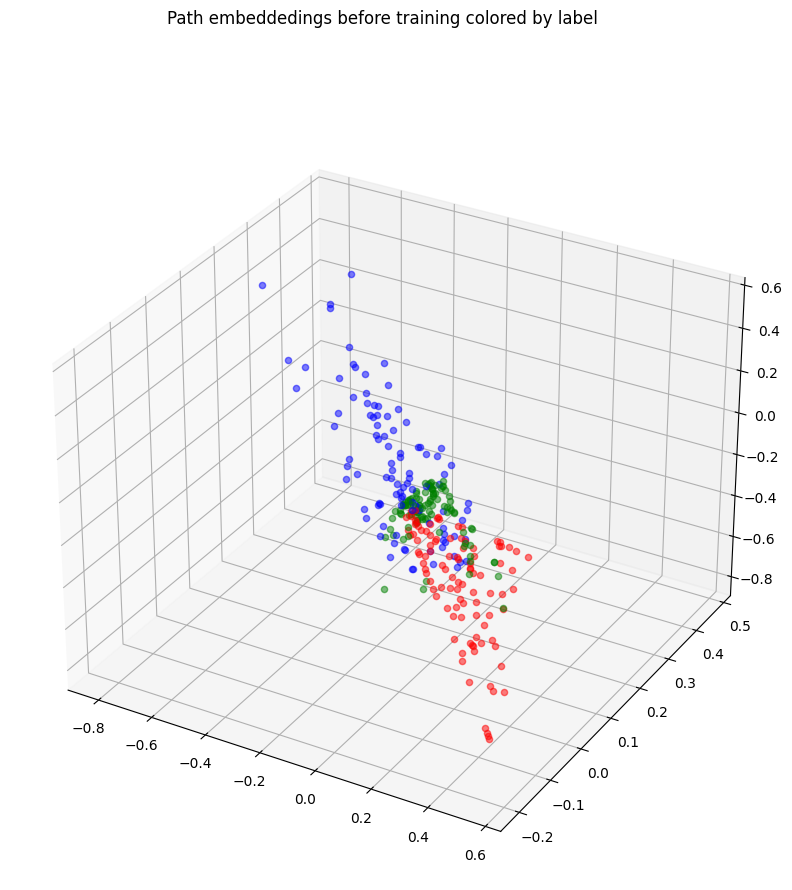

In [66]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

correct = 0

for i in range(len(paths)):
        
        p = paths[i]
        l = labels[i]

        p = path_to_chain(p)
        
        X = gen_CDM2(vf, p, d = 5)
        
        X = torch.sum(X, dim = 0)

        lb = torch.argmax(l)

        pred = torch.argmax(torch.nn.functional.softmax(X))

        if pred == lb:
            correct +=1
        
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'green', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'red', alpha = 0.5)
        elif lb == 2:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'blue', alpha = 0.5)


print('Accuracy: {}'.format(correct/len(paths)))


# add a title to the figure
fig.suptitle('Path embeddedings before training colored by label')

plt.show()

In [67]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(vf.parameters(), lr=1e-2)

criterion = nn.CrossEntropyLoss()


In [68]:
# import clear_output function
from IPython.display import clear_output


/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_806/3535288834.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(X)


Epoch =  0 Loss =  tensor(0.9857) 

Epoch =  1 Loss =  tensor(0.8255) 

Epoch =  2 Loss =  tensor(0.7736) 

Epoch =  3 Loss =  tensor(0.7517) 

Epoch =  4 Loss =  tensor(0.7349) 

Epoch =  5 Loss =  tensor(0.7109) 

Epoch =  6 Loss =  tensor(0.6867) 

Epoch =  7 Loss =  tensor(0.6706) 

Epoch =  8 Loss =  tensor(0.6587) 

Epoch =  9 Loss =  tensor(0.6492) 

Epoch =  10 Loss =  tensor(0.6414) 

Epoch =  11 Loss =  tensor(0.6351) 

Epoch =  12 Loss =  tensor(0.6295) 

Epoch =  13 Loss =  tensor(0.6250) 

Epoch =  14 Loss =  tensor(0.6211) 

Epoch =  15 Loss =  tensor(0.6172) 

Epoch =  16 Loss =  tensor(0.6138) 

Epoch =  17 Loss =  tensor(0.6110) 

Epoch =  18 Loss =  tensor(0.6089) 

Epoch =  19 Loss =  tensor(0.6064) 

Epoch =  20 Loss =  tensor(0.6044) 

Epoch =  21 Loss =  tensor(0.6026) 

Epoch =  22 Loss =  tensor(0.6008) 

Epoch =  23 Loss =  tensor(0.5992) 

Epoch =  24 Loss =  tensor(0.5976) 

Epoch =  25 Loss =  tensor(0.5963) 

Epoch =  26 Loss =  tensor(0.5951) 

Epoch =  27

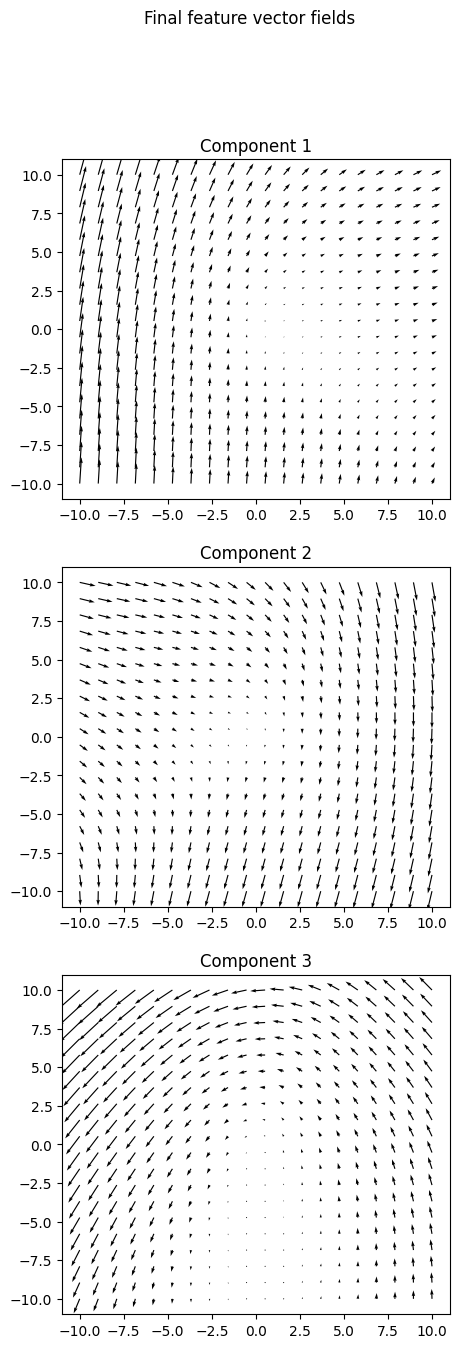

In [69]:
epochs = 50

batch_size = 300

losses = torch.zeros((batch_size,epochs))

for j in range(epochs):

    # make a random choice of size batch_size
    idx = np.random.choice(len(paths), size=batch_size, replace=False)

    batch_paths = [paths[i] for i in idx]
    batch_labels = labels[idx]

        
    for i in range(batch_size):

        p = batch_paths[i]
        l = batch_labels[i]

        p = path_to_chain(p)
        
        X = gen_CDM2(vf, p, d = 5)
        X = torch.sum(X, dim = 0)

        sm = torch.nn.functional.softmax(X)


        loss = criterion(sm,l.float())

        losses[i,j] = loss.detach()

        
        loss.backward()

        # for some reason it works better doing the backprop/gradient step after each path

        optimizer.step()

        optimizer.zero_grad()

    # clear print statement from previous iteration
    # clear_output(wait=True)
    
    print("Epoch = ", j, "Loss = ", torch.sum(losses[:,j])/batch_size, "\n")


fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i in range(3):
    ax = axs[i]
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)
    ax.set_title('Component {}'.format(i+1))

# add a title to the figure
fig.suptitle('Final feature vector fields')

plt.show()

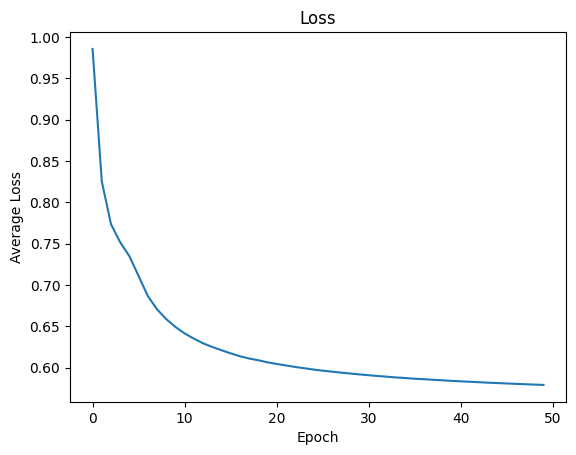

In [70]:
# plot the loss
L = torch.sum(losses,axis=0)/batch_size
plt.plot(L)
plt.title('Loss')

# add x and y labels

plt.xlabel('Epoch')
plt.ylabel('Average Loss')


plt.show()


/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_806/1883341664.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy of the network on the 300 training paths: 98 %


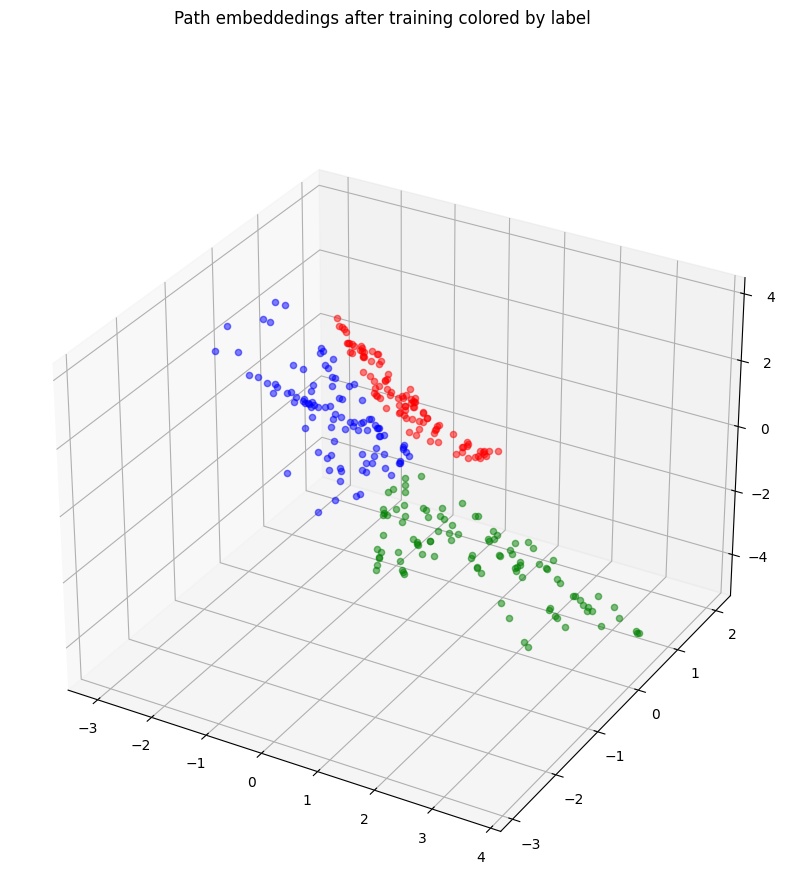

In [71]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

# evaluate the accuracy of the classifier on the training data
correct = 0
total = 0

for i in range(len(paths)):
        
        p = paths[i]
        l = labels[i]
        
        p = path_to_chain(p)
        X = gen_CDM2(vf, p)
        
        X = torch.sum(X, dim = 0)/path_length(p)

        lb = torch.argmax(l)

        pred = torch.argmax(torch.nn.functional.softmax(X))

        if pred == torch.argmax(l):
                correct += 1
        total += 1
        
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'green', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'red', alpha = 0.5)
        elif lb == 2:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'blue', alpha = 0.5)


print('Accuracy of the network on the 300 training paths: %d %%' % (100 * correct / total))

# add a title to the figure
fig.suptitle('Path embeddedings after training colored by label')

plt.show()



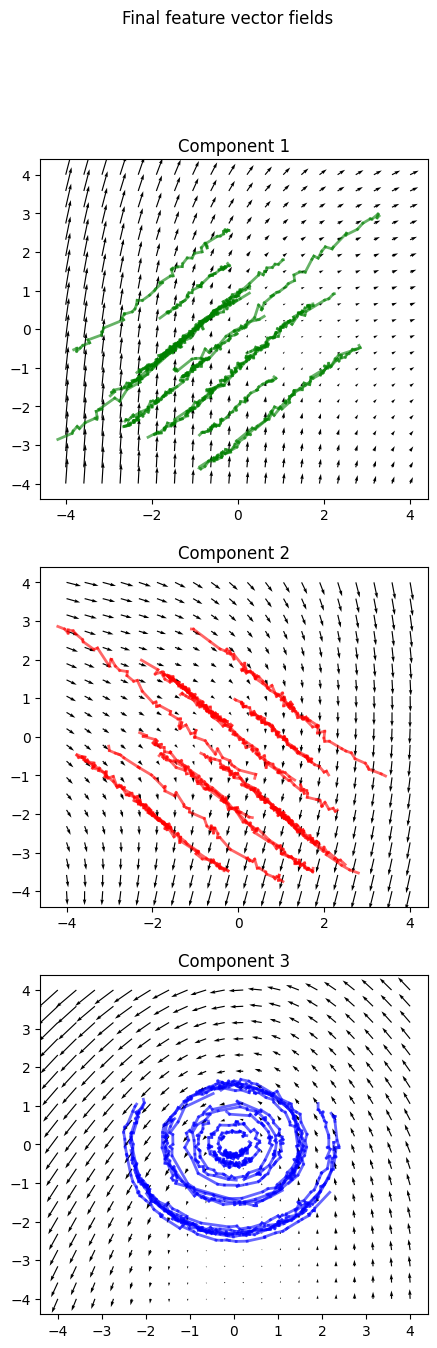

In [72]:
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i in range(3):
    ax = axs[i]
    plot_component_vf(vf, ax, comp = i, x_range=4, y_range=4)
    ax.set_title('Component {}'.format(i+1))

# add a title to the figure
fig.suptitle('Final feature vector fields')



for i in range(20):

    plot_points(paths[0+i], axs[0], color = 'green', alpha = 0.6, linewidth = 2)

    plot_points(paths[100+i], axs[1], color = 'red', alpha = 0.6, linewidth = 2)

    plot_points(paths[200+i], axs[2], color = 'blue', alpha = 0.6, linewidth = 2)

plt.show()

## Check with manual initial weights

In [186]:
class LengthSigmoid(nn.Module):
    """
    A custom layer that takes normalises the vectors in the vector field
    by the sigmoid of their norm
    """
    def __init__(self, m):
        super().__init__()
        self.m = m # embedding dimension

    def forward(self, x):
        x = x.reshape(self.m,-1)
        lengths = torch.diag(torch.sqrt(x.T @ x))

        x = x * (1/lengths)

        x = x * torch.sigmoid(lengths)

        x = x.reshape(1,-1)

        return x


In [181]:
vf2 = nn.Sequential(
    nn.Linear(2, 6),
    LengthSigmoid(2),
)

In [182]:
vf2[0].weight.data = torch.tensor([[0,0],[0,0],[0,-1],[0,0],[0,0],[1,0]], dtype=torch.float)

In [183]:
vf2[0].bias.data = torch.tensor([1,1,0,1,-1,0], dtype=torch.float)

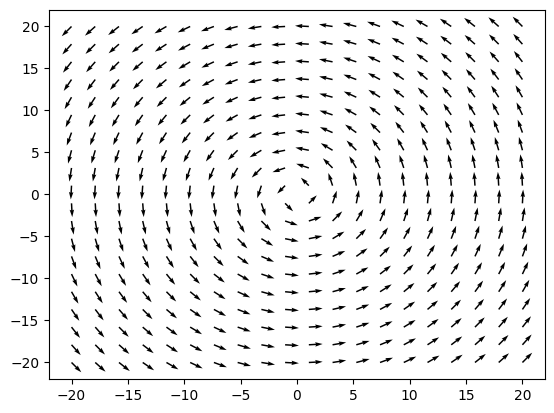

In [184]:
fig, ax = plt.subplots()

plot_component_vf(vf2, ax, comp=2, x_range=20, y_range=20)

plt.show()

In [175]:
orig_labels = np.concatenate((np.zeros(100),np.ones(100),2*np.ones(100)))


correct_pred = 0

for i in range(len(paths)):

    p = paths[i]
    y = labels[i]
    
    X = generate_cochain_dm(vf2, p, n = 5)

    # sum up columns of X using torch
    X = torch.sum(X, dim = 0)

    sm = torch.nn.functional.softmax(X)

    # get the index of the max log-probability
    pred = sm.argmax(dim=0, keepdim=True)

    if pred == orig_labels[i]:
        correct_pred += 1
    




print(correct_pred/len(paths))

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_822/4080481592.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(X)


1.0


In [89]:
X = generate_cochain_dm(vf2, paths[0], n = 5)
X


tensor([[ 0.1314, -0.0144, -0.5052],
        [ 0.0529, -0.1338, -0.3612],
        [ 0.1415,  0.0312, -0.4657],
        [ 0.1104, -0.3317, -0.8718],
        [ 0.1013,  0.0279, -0.2888],
        [ 0.2651,  0.0974, -0.7158],
        [ 0.2787, -0.5371, -1.9705],
        [ 0.4951, -0.2496, -1.9624],
        [ 0.2668, -0.4062, -1.7850]], grad_fn=<CopySlices>)

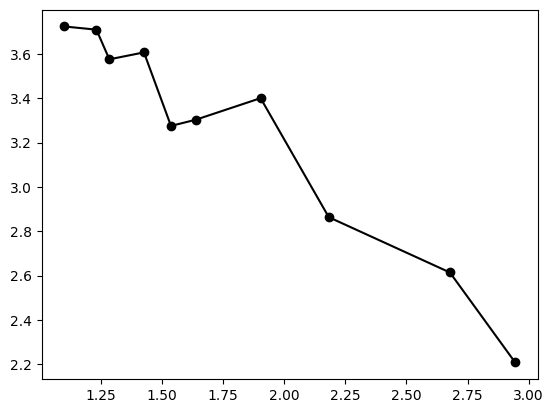

In [107]:
# write a function to plot a path as a scatter with lines joining the points
def plot_path(path, ax, color = 'black'):
    ax.scatter(path[:,0], path[:,1], color = color)
    for i in range(len(path)-1):
        ax.plot(path[i:i+2,0], path[i:i+2,1], color = color)

fig, ax = plt.subplots()

plot_path(paths[0], ax, color = 'black')



tensor([[-1.1477, -1.2494,  1.9954],
        [-2.5538, -0.5393,  2.9158],
        [ 0.1183,  0.4149,  0.0976],
        [-0.5279,  0.1472,  0.6389],
        [-0.7230,  2.3516,  2.5981],
        [ 0.4550,  1.1439,  1.4163],
        [ 1.1423,  0.8550,  1.6691],
        [ 3.2466, -2.0602,  3.1082],
        [-0.3627, -0.8486,  1.0109]], grad_fn=<CopySlices>)
prediction:  [0. 0. 1.] label:  tensor([0, 0, 1])


/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_822/3871740759.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(torch.sum(X,axis=0))


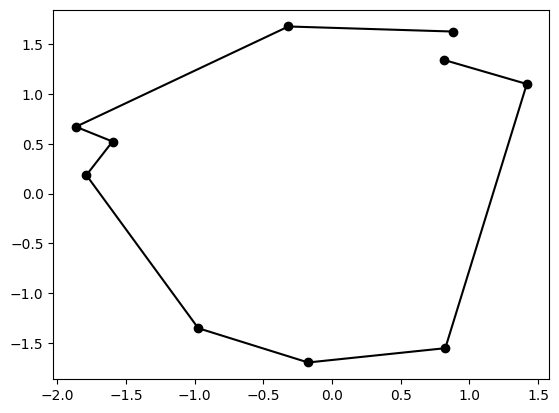

In [126]:
k = 260

X = generate_cochain_dm(vf2, paths[k], n = 5)

print(X)

pred = torch.nn.functional.softmax(torch.sum(X,axis=0))

# display the predictions up to 3 decimal places
print("prediction: ", np.round(pred.detach().numpy(),2), "label: ", labels[k])



fig, ax = plt.subplots()

plot_path(paths[k], ax, color = 'black')

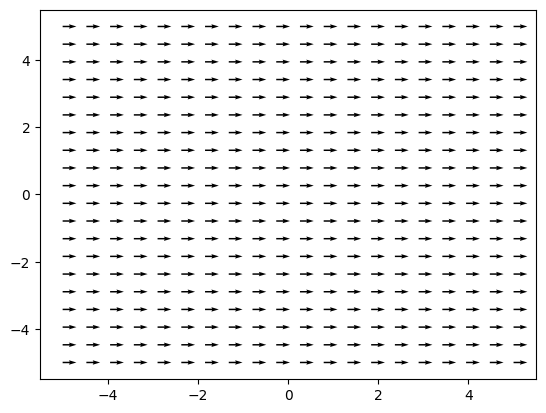

In [99]:
fig, ax = plt.subplots()

plot_component_vf(vf2, ax, comp=0, x_range=-5, y_range=5)

plt.show()